# <font  color = "#0093AF"> Relaxation in complex sequences: RECRR

A challenge in acquiring $R_{1\rho}$ relaxation rate constants is that coherent oscillation is present at the beginning of the $R_{1\rho}$ period, which distorts the signal decay. While we could wait until oscillation is subsided, the beginning of the relaxation period is particularly important, because $R_{1\rho}$ relaxation is multiexponential. The initial slope of decay gives the averaged rate constant, which is what we would like to acquire. However, after time, the faster relaxing components have decayed more than the slower components, so that the slope no longer represents the average rate constant.

Keeler et al. propose a solution to suppress oscillation at the beginning of the $R_{1\rho}$ period, referred to as the REfocused CSA Rotating-frame Relaxation experiment (RECRR). In this experiment, the spin-locks (CW$_{\pm x}$)  are switched in phase, and $\pi$-pulses are inserted to invert the magnetization, as follows:$^1$ 

CW$_x$ - $\pi_y$ - CW$_{-x}$ – CW$_{-x}$ - $\pi_{-y}$ CW$_x$

The spin-locks each have an integer number of rotor periods.

We will investigate the RECRR here and compare its performance to the standard $R_{1\rho}$ experiment

[1] E.G. Keeler, K.J. Fritzsching, A.E. McDermott. *[J. Magn. Reson](https://doi.org/10.1016/j.jmr.2018.09.004)*, **2018**, 296, 130-137.

## Setup

In [2]:
# SETUP SLEEPY
import os
os.chdir('../../../')

In [3]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system and Liouvillian

In [90]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=16000,pwdavg=sl.PowderAvg(),n_gamma=50)
ex0.set_inter('dipole',i0=0,i1=1,delta=44000)
ex0.set_inter('CSA',i=0,delta=113,euler=[0,23*np.pi/180,0])
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,15*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=113,euler=[[0,23*np.pi/180,0],[0,15*np.pi/180,0]])

L=sl.Liouvillian(ex0,ex1)
# L.kex=sl.Tools.twoSite_kex(tc=200e-6)
_=L.add_relax('SpinDiffusion',i=1,k=100)

## Build the propagators and density matrices.
We build the spin-locks on $x$ and $-x$, and $\pi$-pulses on $y$ and $-y$

Density matrix for $R_{1\rho}$ and RECRR sequences are also constructed, including a basis set reduction for propagators and density matrices.

In [91]:
Ux=L.Sequence().add_channel('15N',v1=25000).U()
Umx=L.Sequence().add_channel('15N',v1=25000,phase=np.pi).U()
Upiy=L.Udelta('15N',phase=np.pi/2)
Upimy=L.Udelta('15N',phase=3*np.pi/2)

R1p=sl.Rho('15Nx','15Nx')

R1p,Ux,Umx,Upiy,Upimy=R1p.ReducedSetup(Ux,Umx,Upiy,Upimy)
RECRR=R1p.copy_reduced()

State-space reduction: 32->16


The basic $R_{1\rho}$ experiment only requires repetition of the `Ux` propagator, so we can simply use the `DetProp` function

## Propagation and plotting

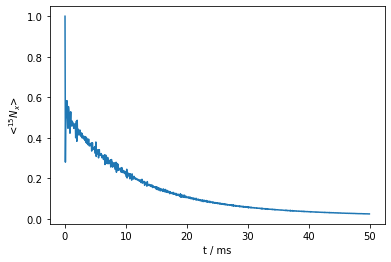

In [92]:
R1p.DetProp(Ux,n=800)
_=R1p.plot()

At the beginning of the decay, we observe a loss of almost half of the signal, due to coherent contributions.

We can also compare the the RECRR. Since additional rotor periods must be inserted into each of four spin-lock blocks, we cannot use the `DetProp` function. We do accelerate the calculation by building up the $x$ and $-x$ spin locks at each loop step, instead of recalculating `Ux**k` and `Umx**k` at every step.

<AxesSubplot:xlabel='t / ms', ylabel='<$^{15}N_x$>'>

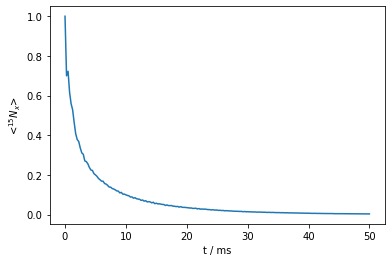

In [62]:
Umx0=Umx
Ux0=Ux
RECRR()
for k in range(200):
    RECRR.reset()
    (Umx0*Upimy*Umx0*Ux0*Upiy*Ux0*RECRR)()
    Umx0=Umx*Umx0
    Ux0=Ux*Ux0
_=RECRR.plot()

Indeed, oscillations at the beginning of the decay curve have been almost entirely removed. However, it is worth noting that the decay rate at the beginning of the curve appears to be faster than with the standard $R_{1\rho}$ experiment. We overlay the two curves, scaling the RECRR curve to match the beginning of the non-coherent decay of the $R_{1\rho}$ curve.

## Single crystal behavior

State-space reduction: 32->16


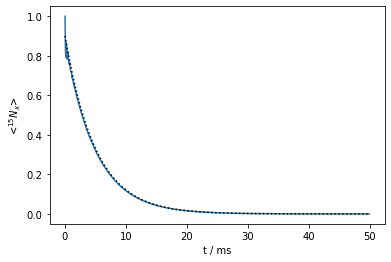

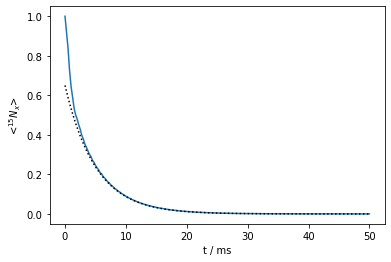

In [94]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=16000,pwdavg=sl.PowderAvg()[3],n_gamma=50)
ex0.set_inter('dipole',i0=0,i1=1,delta=44000)
ex0.set_inter('CSA',i=0,delta=113,euler=[0,23*np.pi/180,0])
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,15*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=113,euler=[[0,23*np.pi/180,0],[0,15*np.pi/180,0]])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=200e-6)
# SpinDiffusion makes the relaxation closer to monoexponential
L.add_relax('SpinDiffusion',i=1,k=100)

Ux=L.Sequence().add_channel('15N',v1=25000).U()
Umx=L.Sequence().add_channel('15N',v1=25000,phase=np.pi).U()
Upiy=L.Udelta('15N',phase=np.pi/2)
Upimy=L.Udelta('15N',phase=3*np.pi/2)

R1p=sl.Rho('15Nx','15Nx')

R1p,Ux,Umx,Upiy,Upimy=R1p.ReducedSetup(Ux,Umx,Upiy,Upimy)
RECRR=R1p.copy_reduced()

r1p=R1p.extract_decay_rates(Ux,pwdavg=True)
R1p.DetProp(Ux,n=800)

ax=R1p.plot()
R1p.reset()
sc=0.9

ax.plot(R1p.t_axis*1e3,
        sc*np.exp(-R1p.t_axis*r1p),linestyle=':',color='black')

Umx0=Umx
Ux0=Ux
RECRR()
for k in range(200):
    RECRR.reset()
    (Umx0*Upimy*Umx0*Ux0*Upiy*Ux0*RECRR)()
    Umx0=Umx*Umx0
    Ux0=Ux*Ux0
ax=RECRR.plot()
_=ax.plot(R1p.t_axis*1e3,
        0.65*np.exp(-R1p.t_axis*R1p.extract_decay_rates(Ux,pwdavg=True)),
       linestyle=':',color='black')